# DFL - Decision-Focused Learning for VRPs

In [1]:
from util import parse_datafile
import torch
import numpy as np
import torch.nn as nn
from solver import GurobiSolver

In [17]:
class SPOplusFunction(torch.autograd.Function):
    """
    The SPO+ function as described in the paper Smart “Predict, then Optimize" https://arxiv.org/abs/1710.08005
    """

    @staticmethod
    def forward(ctx, *args):
        # unpack the arguments
        pred_costs, actual_solution, actual_obj, vrp = args
        device = pred_costs.device
        # solve the VRP with the predicted edge costs
        solver = GurobiSolver(vrp)
        solver.enable_spo_objective()
        solver.solve()
        predicted_solution = solver.get_decision_variables()
        predicted_obj = solver.get_obj_val()
        # calculate the loss
        loss = -predicted_obj + 2 * np.dot(pred_costs, actual_solution) - actual_obj
        loss = torch.FloatTensor(np.array(loss)).to(device)
        predicted_solution = torch.FloatTensor(np.array(predicted_solution)).to(device)
        ctx.save_for_backward(torch.FloatTensor(actual_solution).to(device), predicted_solution)
        return loss

    @staticmethod
    def backward(ctx, *args):
        # unpack the arguments
        grad_loss, = args
        actual_solution, predicted_solution = ctx.saved_tensors
        return grad_loss * 2 * (actual_solution - predicted_solution), None, None, None, None


class SPOplus(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.spoPlusFunction = SPOplusFunction()

    def forward(self, *args):
        return self.spoPlusFunction.apply(*args)


class CostPredictor(torch.nn.Module):
    """
    A simple neural network that predicts the edge costs of a VRP.

    The input is a vector of edge features, the output is a vector of edge costs.
    """

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.fc(x)


In [30]:
vrps_train = [parse_datafile(f'../data/non_linear_1000_25/instance_{i}') for i in range(18)]
vrps_test = [parse_datafile(f'../data/non_linear_1000_25/instance_{i}') for i in range(18, 20)]

In [40]:
vrps_train = [parse_datafile(f'../data/generated_1000_50/instance_{i}') for i in range(18)]
vrps_test = [parse_datafile(f'../data/generated_1000_50/instance_{i}') for i in range(18, 20)]

In [41]:
num_edges = len(vrps_train[0].edges)
num_features = len(vrps_train[0].edges[0].features)

cost_model = CostPredictor(num_edges * num_features, 100, num_edges)
optimizer = torch.optim.Adam(cost_model.parameters(), lr=0.01)
spo_plus = SPOplus()

# training
num_epochs = 10

for epoch in range(num_epochs):
    for vrp in vrps_train:
        optimizer.zero_grad()
        # get the edge features
        edge_features = torch.tensor([edge.features for edge in vrp.edges], dtype=torch.float32)
        edge_features = edge_features.view(-1)
        # predict the edge costs
        predicted_edge_costs = cost_model(edge_features)
        # set the predicted edge costs
        for i, edge in enumerate(vrp.edges):
            edge.predicted_cost = predicted_edge_costs[i]
        # solve the VRP
        solver = GurobiSolver(vrp)
        solver.solve()
        actual_solution = solver.get_decision_variables()
        actual_obj = solver.get_obj_val()
        # calculate the loss
        loss = spo_plus(predicted_edge_costs, actual_solution, actual_obj, vrp)
        # backpropagation
        loss.backward()
        optimizer.step()
        print(f'Loss: {loss.item()}')
        print(f'Actual obj: {actual_obj}')
    print(f'Epoch {epoch} finished')


Set parameter TimeLimit to value 1
Set parameter TimeLimit to value 1
Loss: 14491.48046875
Actual obj: 17168.559999999998
Set parameter TimeLimit to value 1
Set parameter TimeLimit to value 1
Loss: 717071.9375
Actual obj: 17249.309999999998
Set parameter TimeLimit to value 1
Set parameter TimeLimit to value 1
Loss: 466866.03125
Actual obj: 17300.340000000007
Set parameter TimeLimit to value 1
Set parameter TimeLimit to value 1
Loss: 330314.15625
Actual obj: 16932.44
Set parameter TimeLimit to value 1
Set parameter TimeLimit to value 1
Loss: 133091.03125
Actual obj: 17002.62
Set parameter TimeLimit to value 1
Set parameter TimeLimit to value 1
Loss: 66733.28125
Actual obj: 18033.69000000001
Set parameter TimeLimit to value 1
Set parameter TimeLimit to value 1
Loss: 21286.701171875
Actual obj: 17091.380000000005
Set parameter TimeLimit to value 1
Set parameter TimeLimit to value 1
Loss: 5872.568359375
Actual obj: 16607.190000000002
Set parameter TimeLimit to value 1
Set parameter TimeLim

Set parameter TimeLimit to value 1


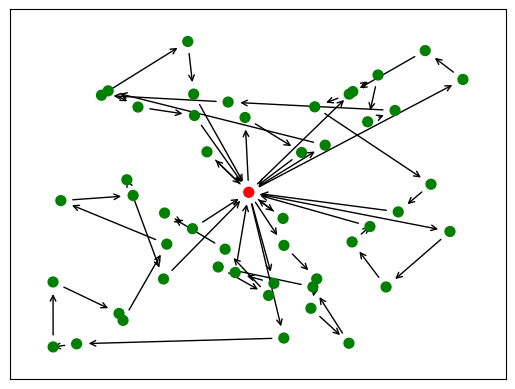

In [42]:
from util import draw_solution

# testing
test = vrps_test[0]

solver = GurobiSolver(test, time_limit=1)
solver.solve()
draw_solution(solver)

Set parameter TimeLimit to value 1


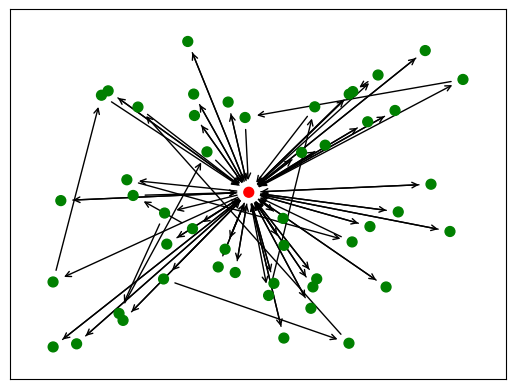

In [43]:
# get the edge features
edge_features = torch.tensor([edge.features for edge in test.edges], dtype=torch.float32)
edge_features = edge_features.view(-1)
# predict the edge costs
predicted_edge_costs = cost_model(edge_features)

# set predicted
for i, edge in enumerate(test.edges):
    edge.predicted_cost = predicted_edge_costs[i]

solver = GurobiSolver(test)
solver.enable_predicted_objective()
solver.solve()
draw_solution(solver)